/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:122: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:122: IntegrationWarning: The integral is probably divergent, or slowly convergent.


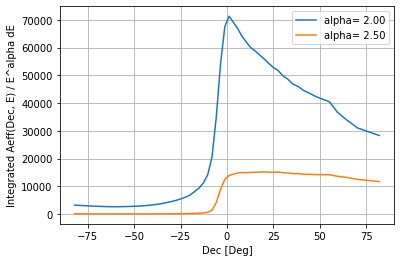

In [3]:
import glob
import scipy.interpolate
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



def load_Aeff(input_file_names, output_file_name, alpha=2.5, verbose=False):
    """
    Loads IceCube detector effective volume, averages it by
    detector type (number of strings IceCube had deployed),
    and integrating over energy and the neutrino flux.
    Parameters
    ----------
    input_file_names : array
        File locations of the IceCube's effective area files.
    output_file_name : str
        Output file location of processed effective area file.
    alpha : float
        Neutrino energy spectrum integrated with the effective area.
    Returns
    ----------
    x_dec_steps : array
        Declination steps of integrated and averaged Aeff.
    y_integrate_steps : array
        Resulting integrated and averaged Aeff.
    """

    data_E = np.array([])
    data_dec = np.array([])

    data_Aeff2 = np.array([])

    df = pd.DataFrame()    
    for data_file in input_file_names:
        df = pd.concat([df, pd.read_fwf(data_file, header=None, skiprows=1)])

    data_E = (df[0].to_numpy() + df[1].to_numpy()) / 2
    data_dec = (df[2].to_numpy() + df[3].to_numpy()) / 2
    data_Aeff2 = df[4].to_numpy()
    data_E_split = np.empty([5,2000])
    data_dec_split = np.empty([5,2000])
    data_Aeff_split = np.empty([5,2000])

    
    
    
    data_E = np.power(10.0, data_E) / 1000.0 # convert to TeV

    for k in range(5):
        for i in range(2000): 
            data_E_split[k,i]=data_E[i +k*2000] #59
            data_dec_split[k,i] = data_dec[i +k*2000] 
            data_Aeff_split[k,i] = data_Aeff2[i +k*2000] 

    data_Aeff3 = np.mean(data_Aeff_split,axis=0)
    
    data_Aeff_split[0] *= 0.0943
    data_Aeff_split[1] *= 0.1201
    data_Aeff_split[2] *= 0.0326
    data_Aeff_split[3] *= 0.6710
    data_Aeff_split[4] *= 0.0826
    
    data_Aeff = np.sum(data_Aeff_split,axis=0)
    data_dec = np.zeros(2000)
    data_E = np.zeros(2000)
    data_dec = data_dec_split[0]
    data_E = data_E_split[0]
    
    # So, now have to integrate Aeff as function of declination
    unique_decs = np.unique(data_dec)
    x_dec_steps = np.zeros(len(unique_decs))
    pure_aeff = np.zeros(len(unique_decs))
    y_integrate_steps = np.zeros(len(unique_decs))
    for i_unique_decs, unique_decs in enumerate(unique_decs):
        cur_E_max = data_E[data_dec == unique_decs]
        ##print(len(cur_E_max))
        cur_Aeff = data_Aeff[data_dec == unique_decs]

        allowed_events = cur_Aeff != 0.0
        cur_E_max = cur_E_max[allowed_events]
        cur_Aeff = cur_Aeff[allowed_events]
        
        
        argsort_ = np.argsort(cur_E_max)
        cur_E_max = cur_E_max[argsort_]
        cur_Aeff = cur_Aeff[argsort_]
        
        
        # so the Aeff is different year on year
        # better ways to solve it, but for now just average
        unique_energies = np.unique(cur_E_max)
        unique_Aeff = np.zeros(len(unique_energies))
        cur_dec = np.zeros(len(unique_Aeff))
        
        
        
        for i in range(len(unique_Aeff)):
            unique_Aeff[i] = cur_Aeff[cur_E_max == unique_energies[i]]
            cur_dec[i] = unique_decs
            #print(unique_Aeff[i]==np.mean(cur_Aeff[cur_E_max == unique_energies[i]]))
        #print(len(unique_Aeff))
        #print(unique_Aeff)
        #print(unique_energies)
        # functional time
        #print(len(unique_energies))
        
        
        
        
        f_integrand = scipy.interpolate.interp1d(unique_energies,
                                                 np.power(unique_energies, -alpha) * unique_Aeff,
                                                 kind='linear',
                                                 bounds_error=False,
                                                 fill_value=0)
   
        integrated_Aeff, int_Aeff_error = scipy.integrate.quad(f_integrand,
                                                               np.min(unique_energies),
                                                               np.max(unique_energies),
                                                               limit=5000)

        x_dec_steps[i_unique_decs] = unique_decs
        y_integrate_steps[i_unique_decs] = integrated_Aeff

        if(verbose):
            print("%i \t %.2f \t %.2f \t %.2f \t %.2f " % (i_unique_decs,
                                                           unique_decs,
                                                           np.min(cur_E_max),
                                                           np.max(cur_E_max),
                                                           integrated_Aeff))
    # sort steps, just in case
    x_dec_steps, y_integrate_steps = zip(*sorted(zip(x_dec_steps, y_integrate_steps)))
    x_dec_steps = np.array(x_dec_steps)
    y_integrate_steps = np.array(y_integrate_steps)

    x_dec_steps = x_dec_steps[y_integrate_steps > 0.0]
    y_integrate_steps = y_integrate_steps[y_integrate_steps > 0.0]

    x_dec_steps = x_dec_steps[np.logical_not(np.isinf(y_integrate_steps))]
    y_integrate_steps = y_integrate_steps[np.logical_not(np.isinf(y_integrate_steps))]
    
    y_integrate_steps = np.delete(y_integrate_steps,32)
    y_integrate_steps = np.delete(y_integrate_steps,26)

    
    x_dec_steps = np.delete(x_dec_steps,32)
    x_dec_steps = np.delete(x_dec_steps,26)

    
    pure_aeff = np.delete(pure_aeff,32)
    pure_aeff = np.delete(pure_aeff,26)
    
    
    np.savez(output_file_name,
             dec=x_dec_steps,
             Aeffintegrated=y_integrate_steps)
    
    

    
    return x_dec_steps, y_integrate_steps


if(__name__ == "__main__"):

    input_file_names = glob.glob("./data/tabulatedaeff/IC*.txt")

    for alpha in [2.0, 2.5]:
        output_file_name = "./processed_data/output_icecube_AffIntegrated_%s.npz" % alpha
        
        
        dec_steps, y_integrate_steps = load_Aeff(input_file_names, output_file_name, alpha)


        plt.plot(dec_steps, y_integrate_steps, label="alpha= %.2f" % alpha)

    plt.xlabel("Dec [Deg]")
    plt.ylabel("Integrated Aeff(Dec, E) / E^alpha dE")
    plt.grid()
    plt.legend()
    plt.show()

    
    
    plt.show()